# 1. Problem undestanding

First, it is important to understand that a portfolio is no more than just a collection of stock investments held by an investor. Optimizing a financial portfolio requires selecting the best possible portfolio out of a set of all portfolios being considered according to an objective.

According to modern portfolio theory, one possible way to optimize a portfolio is to aim for an efficient frontier. The efficient frontier is a investment portfolio that lies on the most efficient(ideal) coordinates of the risk-return graph(spectrum). There is a formal definition that is used by many experts in this field, "Efficient frontier is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return.

Now we know the aim is to achieve one of the efficient frontier portfolios. However, we can even go one step further than the overall portfolio. We can identify the best possible proportion of the stocks to use in any given portfolio. This is possible by using the sharpe ratio.

The sharpe ratio was developed by William Sharpe in 1966. The sharpe ratio describes how much excess return of money one recieves for the extra volatile time he/she holds onto the investment. Basically, it measures how much extra capital money one can recieve by waiting and holding onto a risky stock investment. The sharpe ratio can be calculated by taking the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment.

Usually experts define four categories for the result of the sharpe ratio:

Sharpe Ratio	Category
* ratio < 1.0	sub-optimal
* ratio > 1.0	good
* ratio > 2.0	very good
* ratio > 3.0	excellent

After considering the efficient frontier theory, as well as the sharpe ratio, it is time to start the code to optimize a sample financial portfolio.



# 2. Import dependencies

In [1]:
!pip install 'git+https://github.com/cvxgrp/cvxpy.git#egg=cvxpy[glpk]'

!pip install PyPortfolioOpt

!pip install plotly

!pip install tqdm

  Cloning https://github.com/cvxgrp/cvxpy.git to /tmp/pip-install-rc3me_k6/cvxpy_ebedf64db12c4ba0b8fa590a30a2f24c
  Running command git clone --filter=blob:none --quiet https://github.com/cvxgrp/cvxpy.git /tmp/pip-install-rc3me_k6/cvxpy_ebedf64db12c4ba0b8fa590a30a2f24c
  Resolved https://github.com/cvxgrp/cvxpy.git to commit 2ef78a5f042f077e519258f5cc203a4a4ea72d16
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... - \ | / - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.5 MB/s eta 0:00:00
  Created wheel for cvxpy: filename=cvxpy-1.3.0-cp3

In [2]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import discrete_allocation 

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import plotly.graph_objects as go
from tqdm import tqdm
import copy
import os
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Transforming the data
> Combining the multiple CSV files into a single one, so it gets easier to manipulate

In [3]:
def create_df(location):
    df = pd.DataFrame()

    all_files = []
    data = location
    for path, subdirs, files in os.walk(data):
        for name in files:
            all_files.append(os.path.join(path, name))
            
    df.index = pd.read_csv(all_files[0] ,parse_dates = True, index_col = 'Date').index
    
    k = 0
    for item in all_files:
        df_item = pd.read_csv(item ,parse_dates = True, index_col = 'Date')
        df_name = item[item.rfind('/')+1:item.rfind('.')]
        df_item.rename(columns = {'Close': df_name }, inplace = True)
        df = pd.concat([df, df_item[df_name]], axis=1, join='inner')
        k+=1
    return df

df_crypto = create_df("../input/reduceddata/datahack_reduced/crypto")

## Plot Individual Stock Prices

> The graph is plotted with plotly library. It is an interactive graph.

In [4]:
fig_price = px.line(df_crypto, title='Price of Individual Stocks')
fig_price.show()

As seen above, Bitcoin seems to dominate the scale of the graph as the absolute price of the stock is very high. The graphs of all other stocks are flattened out. A graph like this is not very useful to compare the relative performance of the stocks. To address this, let's see how we can better measure the performance of a stock by exploring the concepts of daily returns and volatility.

## Daily Returns
The daily returns of a stock is the fractional gain (or loss) on a given day relative to the previous day, it is given by (current day's close price - previous day's close price) / (previous day's close price). As it is a relative value, it provides a fairer comparison between stock returns regardless of absolute stock prices. The pct_change() method can be used to get the daily returns efficiently.

In [5]:
daily_returns = df_crypto.pct_change().dropna()
daily_returns.head()

,TRON,USD Coin,Binance Coin,Dogecoin,Ethereum,XRP,Tether,Bitcoin Cash,Uniswap,Litecoin,Aave,VeChain,THETA,Polkadot,Cardano,Chainlink,Bitcoin,Filecoin,Terra,Stellar
Date,,,,,,,,,,,,,,,,,,,,
2020-11-07,-0.043815,0.000200,-0.044735,-0.031556,-0.044589,-0.036792,0.001600,-0.014716,-0.036590,-0.067702,0.147249,-0.071627,-0.059127,-0.075649,-0.070642,-0.034511,-0.048113,-0.056081,-0.049298,-0.051621
2020-11-08,0.011117,0.000601,0.022334,0.013858,0.044281,0.019400,-0.000599,0.066677,0.160566,0.036887,0.209637,0.071759,0.041373,0.031840,0.052320,0.082553,0.044192,0.026702,0.042582,0.024387
2020-11-09,-0.017536,-0.000100,-0.010218,-0.012560,-0.022763,-0.013278,-0.000599,-0.024789,-0.066982,-0.029413,0.029784,-0.008628,-0.035666,-0.005943,-0.012195,-0.018082,-0.010107,0.029584,-0.019104,-0.023193
2020-11-10,0.000682,-0.000300,0.003560,0.032548,0.013256,0.013217,0.000800,-0.027011,0.147425,-0.023450,0.209508,0.050041,-0.000780,0.016096,0.006648,0.042434,-0.001540,-0.041996,0.036266,0.000251
2020-11-11,0.009059,0.000000,-0.007095,-0.001087,0.029119,0.007685,-0.000100,-0.001324,-0.045852,0.025535,-0.181438,-0.021065,-0.046228,0.008147,0.000000,-0.018433,0.025628,-0.010218,0.037589,0.009043


Let's plot out the daily returns of 3 of the stocks, TRON, USD Coin and Bicoin, throughout the whole time period. We see that they tend to fluctuate gently around 0. Notably, the fluctuations are much greater during a period of high volatility (i.e. during the Covid crash in March 2020).

In [6]:
fig = px.line(daily_returns[['TRON', 'USD Coin','Bitcoin']], title='Daily Returns')
fig.show()

## Volatility

#### Daily Volatility

Daily Volatility is the average difference between the return on a given day and the average return over the time period. Mathematically, it is just the standard deviation of the daily returns. Volatility is one of the measures of risk in that highly volatile investments can carry greater risk.

In [7]:
daily_returns.std()

TRON            0.070508
USD Coin        0.000547
Binance Coin    0.081031
Dogecoin        0.247940
Ethereum        0.058878
XRP             0.097018
Tether          0.000630
Bitcoin Cash    0.075933
Uniswap         0.085497
Litecoin        0.066459
Aave            0.081461
VeChain         0.086830
THETA           0.081007
Polkadot        0.081727
Cardano         0.073899
Chainlink       0.075961
Bitcoin         0.043604
Filecoin        0.081366
Terra           0.112880
Stellar         0.087391
dtype: float64

Here we see that Dogecoin has a slightly higher volatility, compared to that of Bitcoin. When we compare the density plots of their daily returns, we can see that Bitcoin has a narrower curve with a higher peak, while Dogecoin has a wider curve indicating higher standard deviation and hence volatility.

(-0.1, 0.1)

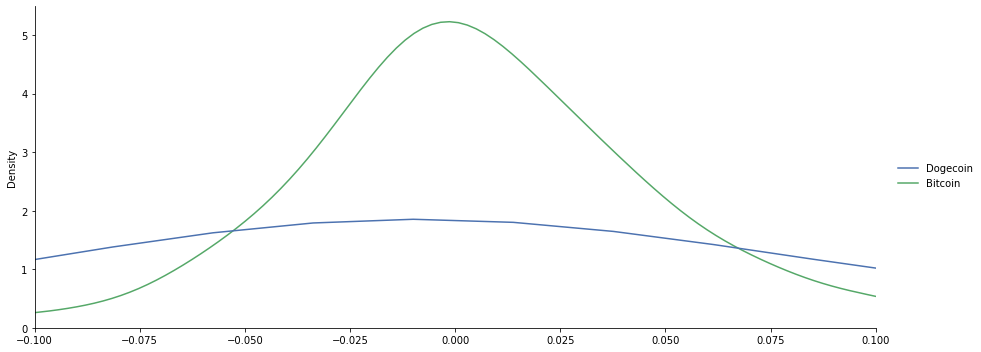

In [8]:
sns.displot(data=daily_returns[['Dogecoin','Bitcoin']], kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

#### Annual Volatility

For completeness, the Annual Volatility is a more common measure can be calculated simply by multiply the daily volatility by the square root of the number of trading days in a year i.e. 252. 

## Plot Correlation Matrix between Stocks
The correlation matrix gives us the correlation coefficients between every pair of stocks. Correlation coefficients are indicators of the strength of the linear relationship between two different variables. It is a value from 0 to 1, with 1 indicating the strongest relationship. If it is a negative value, then the two variables are inversely related. 

In [9]:
def most_correlated(dataframe):
    """
    Returns a dataframe that contains the most correlated features
    
    dataframe: dataframe that gives the column names and their correlation value
    """
    corr_values = dataframe.abs().unstack()
    sorted_values = pd.DataFrame(corr_values.sort_values(kind="quicksort"), index= None)
    sorted_values = sorted_values[(sorted_values[0] > 0.6) & (sorted_values[0] < 1)]
    return sorted_values.drop_duplicates()

In [10]:
corr_df = df_crypto.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, title = 'Correlation between Crypto Stocks')
fig_corr.show()


In [11]:
most_correlated(corr_df)

,,0
Terra,VeChain,0.61
Chainlink,Dogecoin,0.62
Bitcoin,Terra,0.63
Ethereum,Stellar,0.64
Polkadot,Terra,0.65
Uniswap,Dogecoin,0.67
Cardano,Aave,0.68
Terra,TRON,0.69
THETA,Ethereum,0.70
Cardano,VeChain,0.71



In general (though not always), stock prices tend to move together (increase in bull market, decrease in bear market), hence the correlation would most likely be positive as shown above. 
To reduce the size of our given data I am going to delete one of the stocks that have a correlation >0.9

In [12]:
df_crypto = df_crypto.drop(columns=['Litecoin','Cardano','TRON','Stellar','Bitcoin Cash','Polkadot','VeChain','Terra'])

## Optimize portfolio for max Sharpe ratio plot it out with efficient frontier curve
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility) or the lowest risk (volatility) for a given level of expected return. It is represented by a line on a Return vs Volatility graph. The max Sharpe ratio portfolio lies on the efficient frontier. 

To represent everything visually, the code below  generates 1000 portfolios of our stocks with random weights and plot out their returns and volatility. The efficient frontier and the max Sharpe ratio portfolio is also plotted on the graph.

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#-- Store weights and tickers for labelling
result = []
max_sharpe = 0
mu_op=0
S_op =0
for i in tqdm(range(1000)):
    next_i = False
    while True:
        assets = []
        #- Choose assets randomly without replacement
        assets +=list(np.random.choice(df_crypto.columns, 5, replace=False))
        mu = expected_returns.mean_historical_return(df_crypto[assets]) # returns.mean() * 252
        S = risk_models.sample_cov(df_crypto[assets]) # Get the sample covariance matrix
        ef = EfficientFrontier(mu, S)
        try :
            weights = ef.max_sharpe(risk_free_rate=0.05) #Maximize the Sharpe ratio, and get the raw weights
        except:
            continue
        else: 
            cleaned_weights = ef.clean_weights() 
            expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=0.05)
            if sharpe_ratio > max_sharpe:
                max_sharpe = sharpe_ratio
                result = cleaned_weights
                mu_op = mu
                S_op = S
        
        break

100%|██████████| 1000/1000 [00:16<00:00, 60.32it/s]


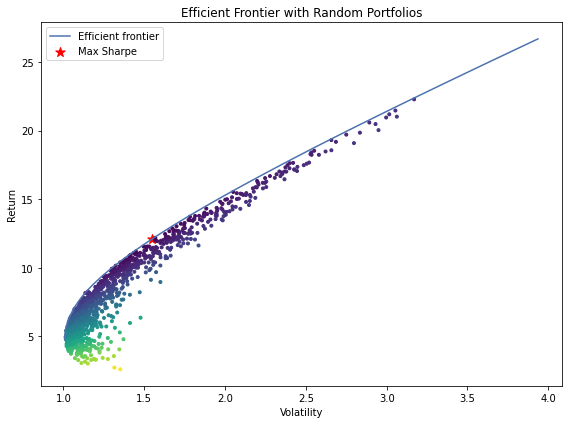

In [14]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.05)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.05)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu_op, S_op)

In the graph above, we see that the efficient frontier is like a boundary. 

## Get Weights for Optimized Portfolio

In [15]:
print(result)

OrderedDict([('THETA', 0.00429), ('Dogecoin', 0.31941), ('Binance Coin', 0.4741), ('XRP', 0.0), ('Uniswap', 0.2022)])


In [16]:
weights_df = pd.DataFrame.from_dict(result, orient = 'index')
weights_df.columns = ['weights']
weights_df

,weights
THETA,0.00429
Dogecoin,0.31941
Binance Coin,0.47410
XRP,0.00000
Uniswap,0.20220


Notice how certain weights tend to dominate by high performing stocks (high returns with relatively ok volatility), while some weights tend to be 0. One of the weakness of the max Sharpe portfolio optimization approach is that the portfolio may not be as diversified (across types of stocks or industries) as we want it to be. Also, as cliche as it may sound, past performance is not indicative of future results. We are obtaining the expected returns and volatility based on the movement of stock prices in the past, the future returns/volatility may very well differ.

## Expected Annual Return, Annual Volatility and Sharpe Ratio for Optimized Portfolio

In [17]:
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=0.05)

print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 486.08%
Annual volatility: 107.25%
Sharpe ratio: 4.49


## Generate Portfolio with Optimized Weights

In [18]:
df_crypto['Optimized Portfolio'] = 0

for ticker, weight in weights.items():
    df_crypto['Optimized Portfolio'] += df_crypto[ticker]*weight

df_crypto.head()

,USD Coin,Binance Coin,Dogecoin,Ethereum,XRP,Tether,Uniswap,Aave,THETA,Chainlink,Bitcoin,Filecoin,Optimized Portfolio
Date,,,,,,,,,,,,,
2020-11-06,0.9986,29.06,0.002757,455.72,0.25848,1.0000,2.5690,38.71,0.6782,12.17,15577.9,31.74,169.518367
2020-11-07,0.9988,27.76,0.002670,435.40,0.24897,1.0016,2.4750,44.41,0.6381,11.75,14828.4,29.96,161.956899
2020-11-08,0.9994,28.38,0.002707,454.68,0.25380,1.0010,2.8724,53.72,0.6645,12.72,15483.7,30.76,168.719854
2020-11-09,0.9993,28.09,0.002673,444.33,0.25043,1.0004,2.6800,55.32,0.6408,12.49,15327.2,31.67,165.118057
2020-11-10,0.9990,28.19,0.002760,450.22,0.25374,1.0012,3.0751,66.91,0.6403,13.02,15303.6,30.34,167.124151


## Plot Cumulative Returns of Optimized Portfolio

In [19]:
latest_prices = discrete_allocation.get_latest_prices(df_crypto[weights_df.index])
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(result, latest_prices, total_portfolio_value=10000).lp_portfolio()
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))

{'THETA': 9, 'Dogecoin': 15998, 'Binance Coin': 14, 'Uniswap': 91}
Leftover Fund value in$ after building minimum volatility portfolio is $28.06
